In [2]:
#matplotlib包用于作图，且设置为嵌入显示
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd,nd
import random

In [3]:
'''第一步：生成数据集'''
#样本数为1000，特征值为2
num_inputs = 2;      #特征值
num_examples = 1000; #样本数
true_w = [2,-3.4];   #真实权重
true_b = 4.2;        #偏差
#接下来我们要看如何生成特征值，生成的行列式是1000行两列的，scale表示标准差为1
#nd.random.normal?
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))

# 输出部分
# Pre：先了解一下下标：
# X[1:2,:]=9; 这个表示的意思是，第一行所有列的值都赋值给为9
#y=x1*w1 + x2*w2 y每一行是一个长度为1的向量，两个x作为特征值，
labels = true_w[0] * features[:,0] + true_w[1]*features[:,1] + true_b;

#噪声，服从均值为0，标准差为0.01的正态分布
labels += nd.random.normal(scale=0.01,shape=labels.shape);


In [3]:
#看下特征值每一行长度为2，输出没一行长度为1
print(features[0],labels[0])


[1.1630785 0.4838046]
<NDArray 2 @cpu(0)> 
[4.879625]
<NDArray 1 @cpu(0)>


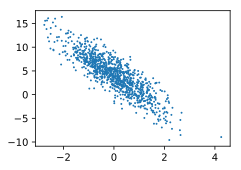

In [4]:
#通过散点图，可以看特征值和输出之间的关系
#eg:通过生成第二个特征features[:,1]和标签labels

#用矢量图显示
def use_svg_display():
    #确定使用矢量图显示
    display.set_matplotlib_formats('svg');

#使用矢量图，并设置尺寸
def set_figsize(figsize=(3.5,2.5)):
    use_svg_display();
    #设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize
    

#调用设置
set_figsize();

#生成我们要观察的图像,调用plt的scatter的函数，加分号值显示图
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1); # 加分号只显⽰图


#上边的作图设置，被我们放在了d2lzh.plt里边，plt在d2lzh包里是一个全局变量，
#我们在作图前只需要调用d2lzh.set_figsize()即可打印矢量图并设置图的尺寸



In [5]:
'''第二步：读取数据集'''

# 本函数已保存在d2lzh包中⽅便以后使⽤
def data_iter(batch_size, features, labels):
    #features的长度
    num_examples = len(features)
    #index数组
    indices = list(range(num_examples))
    random.shuffle(indices) # 样本的读取顺序是随机的
    #ranage参数，start、stop、step
    for i in range(0, num_examples, batch_size):
        #min返回最小值，这里的意思是不超过最大值
        #第一次是从0到10，第二次是11到20
        #因为总数是1000，所以应该是100组
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j) # take函数根据索引返回对应元素

#作个测试，这里返回第一组10个就break
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break;






[[-0.11860341  1.4148241 ]
 [ 0.59673244  1.1476266 ]
 [ 1.3944823   0.56141484]
 [-1.9525608   0.83957785]
 [-0.25059167 -0.06146849]
 [-0.44719613 -1.2024835 ]
 [-1.4682876   0.56517833]
 [-0.3216947  -0.83062977]
 [-0.6552829  -0.69220996]
 [ 1.0849115  -1.2594224 ]]
<NDArray 10x2 @cpu(0)> 
[-0.8272222  1.5031722  5.090474  -2.5533025  3.9101636  7.403172
 -0.6382029  6.375893   5.254281  10.634141 ]
<NDArray 10 @cpu(0)>


In [6]:
'''第三步：初始化模型参数'''
#这里说明一点，我们是通过数据集来渐渐让我们初始化后的模型参数接近我们需要的值的
#  权重初始化：将权重初始化为均值为0，标准差为0.01的正态随机数
#  偏差初始化：偏差初始化为0
w = nd.random.normal(scale=0.01,shape=(num_inputs,1));
b = nd.zeros(shape=(1,))

#之后的模型训练中，需要对这些参数求梯度，来迭代参数的值，因此我们需要创建它们的梯度
#梯度，是由n个偏导数组成的向量，表示模型拉扯的速度
w.attach_grad();
b.attach_grad();

In [7]:
'''第四步：定义模型'''
#下面是线性回归的矢量计算表达式的实现，我们用dot函数做矩阵乘法

def linreg(X,w,b):#本函数已经保存
    return nd.dot(X,w) + b


In [8]:
'''第五步：定义损失函数'''
#使用平方损失来定义线性回归的损失函数
def squared_loss(y_hat,y):   #本函数同样已保存
    #被减数是预测的模型信息，减数是小批量样本的特征和标签
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
    

In [9]:
'''第六步：优化算法：小批量随机梯度下降'''
#它的算法很简单：先选取一组模型参数的初始值，如上边初始化的w,b
#然后对参数进行多次迭代，使每次迭代都可能降低损失函数的值
#so：每次迭代如何进行呢？
#（1）先随机均匀采样一个由固定数目训练数据样本所组成的小批量B（mini-batch）
#（2）然后求小批量中数据样本的平均损失有关模型参数的导数(梯度) PS：注意是平均损失
#（3）最后用学习率和平均损失有段模型参数的导数的乘积，作为一次迭代的减少量


#这里用自动求梯度模块计算来的梯度是一个批量样本的梯度和，我们将它除以批量大小
#来得到平均值

def sgd(params,lr,batch_size):#本函数已保存
    for param in params:
        param[:] = param - lr * param.grad/batch_size


In [13]:
'''第七步：训练模型'''
# 超参数：迭代周期num_epochs;学习率lr为0.03，这两个都是超参数
lr = 0.03;#学习率
num_epochs = 3; #迭代周期设置为3
net = linreg ;  #net为模型函数
loss = squared_loss; #loss是损失函数

#训练模型一共需要num_epochs个训练周期
for epoch in range(num_epochs):
    #在每一个迭代周期里，会使用训练集中所有样本一次(假设样本数能够被批量大小整除)
    #X和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        #前边的attach_grad已经申请出内存了
        #现在开始自动求梯度
        with autograd.record():
            # l 是有关小批量x和Y的损失
            l = loss(net(X,w,b),y);
        #小批量的损失对模型参数求梯度
        #由于l并不是标量，运行l.backward()将对l中元素求和得到一个新的变量，
        #再求该变量有段模型参数的梯度，对和求梯度将在下一个步骤中进行
        l.backward();
        #使用小批量随机梯度下降迭代模型参数，最后会得到这一步优化后的w和b
        sgd([w,b],lr,batch_size);#在这里边会得到前边得到的[w,b]梯度值，用来减
    
    #一波迭代之后，看损失是否减少
    train_l = loss(net(features, w, b), labels);
    #然后查看三次迭代，损失的变化
    print('epoch %d,loss %f ' %(epoch + 1,train_l.mean().asnumpy()));
    

    
#训练完成后，查看真实参数和我们学习到的参数，已经很接近了
print("===========================")
print(true_w,w);
print(true_b,b);





epoch 1,loss 0.000049 
epoch 2,loss 0.000048 
epoch 3,loss 0.000048 
[2, -3.4] 
[[ 1.999196]
 [-3.400069]]
<NDArray 2x1 @cpu(0)>
4.2 
[4.2000885]
<NDArray 1 @cpu(0)>
